In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

### Nạp dữ liệu từ file

In [27]:
# Load the uploaded file to inspect its content
file_path = './ProcessedData.csv'
data = pd.read_csv(file_path)

### Phân bố của các mức AQI

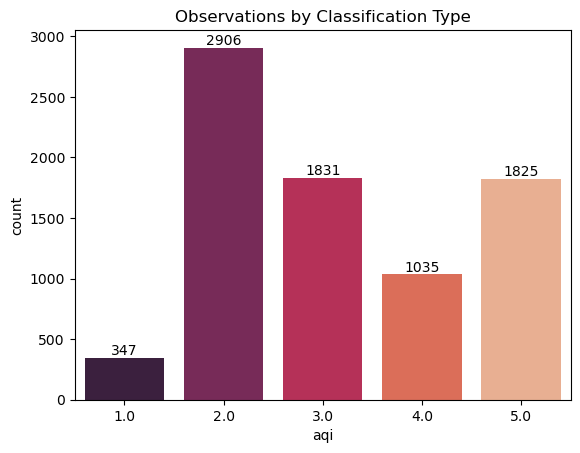

In [28]:
# Explore distribution of data set
# count plot on ouput variable
ax = sns.countplot(x = data['aqi'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

- Dữ liệu tập trung ở mức AQI trung bình (2.0) và mức cao hơn (3.0, 5.0): Điều này phản ánh rằng không khí tại TP.HCM có xu hướng không hoàn toàn trong lành nhưng vẫn ở mức chấp nhận được trong hầu hết thời gian.
- Số liệu ở mức tốt nhất (AQI = 1.0) rất thấp, do khu vực đô thị hóa, giao thông đông đúc, và nguồn ô nhiễm từ các hoạt động công nghiệp.
- Nguy cơ ở mức AQI cao (4.0, 5.0): Các mức này tuy không chiếm ưu thế nhưng vẫn đáng lưu ý, vì chúng gây ảnh hưởng nghiêm trọng đến sức khỏe, đặc biệt với nhóm người nhạy cảm (trẻ em, người già).


#### Dictionary để tham chiếu AQI dựa trên các chỉ số thành phần không khí

In [29]:
aqi_thresholds = {
    'so2': [
        (0, 20), (20, 80), (80, 250), (250, 350), (350, float('inf'))
    ],
    'no2': [
        (0, 40), (40, 70), (70, 150), (150, 200), (200, float('inf'))
    ],
    'pm10': [
        (0, 20), (20, 50), (50, 100), (100, 200), (200, float('inf'))
    ],
    'pm2_5': [
        (0, 10), (10, 25), (25, 50), (50, 75), (75, float('inf'))
    ],
    'o3': [
        (0, 60), (60, 100), (100, 140), (140, 180), (180, float('inf'))
    ],
    'co': [
        (0, 4400), (4400, 9400), (9400, 12400), (12400, 15400), (15400, float('inf'))
    ]
}

#### Trả về danh sách các chất gây ra ô nhiễm dựa trên các thành phần không khí trong 1 dòng

In [30]:
def get_aqi_category_from_array(row, thresholds, pollutant_names):
    """
    Xác định mức AQI của một mảng dữ liệu và trả về các chất ô nhiễm với mức AQI tương ứng.

    Parameters:
    - row: list hoặc numpy array chứa các giá trị của chất ô nhiễm.
    - thresholds: từ điển ngưỡng AQI.
    - pollutant_names: danh sách tên các chất ô nhiễm tương ứng với row.

    Returns:
    - Danh sách các chất ô nhiễm cùng với mức AQI của chúng.
    """
    aqi_details = []  # Danh sách lưu trữ chi tiết các chất ô nhiễm và mức AQI
    for i, pollutant in enumerate(pollutant_names):
        value = row[i]  # Giá trị của chất ô nhiễm tại vị trí i
        for index, (lower, upper) in enumerate(thresholds[pollutant], start=1):
            if lower <= value < upper:
                if index >= 4:
                    aqi_details.append(pollutant)  # Lưu tên chất ô nhiễm và mức AQI
                break
    return aqi_details  # Trả về danh sách các chất ô nhiễm và mức AQI

#### Thêm cột các thành phần gây ra ô nhiễm không khí

In [31]:
def add_pollutant_column(df, thresholds, pollutant_names):
    # Avoid setting a value on a slice by creating a copy
    df = df.copy()
    
    # Add 'pollutant' column
    df['pollutant'] = df.apply(
        lambda row: get_aqi_category_from_array(row[pollutant_names].values, thresholds, pollutant_names),
        axis=1
    )
    
    # Remove rows where 'pollutant' is an empty list
    df = df.loc[df['pollutant'].apply(lambda x: len(x) > 0)]
    
    return df


# Dropping 'Unnamed: 0', 'timestamp', and 'Weather Description' for now
columns_to_drop = ['Unnamed: 0', 'timestamp', 'Weather Description']
air = ['co','no2','o3','so2','pm2_5','pm10']
weather = ['Temprature (Kelvin)','Feels like (Kelvin)','Pressure (mb)',
           'Humidity (%)','Temperature Amplitude','Wind speed (m/s)','Wind degree',
           'Wind gust (m/s)','Clouds all (%)','Rain 1h (mm)']
data = data.drop(columns=columns_to_drop + weather)  # Exclude target column 'aqi'
# Thêm cột 'pollutant' và loại bỏ các dòng rỗng
data = add_pollutant_column(data[air], aqi_thresholds, air)


#### Lưu vào file

In [32]:
data.to_csv('Pollutant.csv', index=False)

#### Biểu đồ tỉ lệ các chất gây ra ô nhiễm không khí

In [33]:
# Tách các phần tử trong cột 'pollutant' thành các dòng riêng biệt
df_exploded = data.explode('pollutant')

# Đếm số lần xuất hiện của mỗi thành phần
pollutant_counts = df_exploded['pollutant'].value_counts()

# Chuyển Series thành DataFrame
pollutant_counts_df = pollutant_counts.reset_index()

# Đổi tên cột để dễ đọc hơn
pollutant_counts_df.columns = ['Pollutant', 'Concentration']

pio.templates.default = "plotly_white"

# Define pollutants and their colors
pollutants = pollutant_counts_df['Pollutant']
pollutant_colors = px.colors.qualitative.Plotly

# Create a donut plot for pollutant concentrations
fig = px.pie(pollutant_counts_df, names="Pollutant", values="Concentration",
             title="Pollutant Concentrations",
             hole=0.4, color_discrete_sequence=pollutant_colors)

# Update layout for the donut plot
fig.update_traces(textinfo="percent+label")
fig.update_layout(legend_title="Pollutant")

# Show the donut plot
fig.show()

* Chất ô nhiễm chiếm tỷ lệ lớn nhất: PM2.5 chiếm 60.6%, đây là loại bụi mịn có kích thước nhỏ hơn 2.5 micromet. Loại này cực kỳ nguy hiểm vì nó có khả năng xâm nhập sâu vào phổi và máu, gây ảnh hưởng nghiêm trọng đến sức khỏe.
Chất ô nhiễm đứng thứ hai:

* PM10 chiếm 38.2%, là loại bụi lớn hơn PM2.5 nhưng vẫn có hại cho đường hô hấp. Sự hiện diện cao của PM10 cùng với PM2.5 cho thấy nguồn ô nhiễm bụi đáng kể (có thể từ giao thông, xây dựng, hoặc hoạt động công nghiệp).

* O3 (ozone): Chỉ chiếm 0.718%, cho thấy ozone mặt đất ở mức thấp trong khu vực được đo.
* NO2 (Nitrogen dioxide): Chỉ chiếm 0.526%, đây là khí thường xuất phát từ giao thông và các nhà máy, nhưng dường như không phải vấn đề chính ở đây.